In [1]:
import gym
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
from collections import defaultdict
from IPython.display import clear_output
# for creating a responsive plot
%matplotlib inline

In [2]:
env = gym.make('Blackjack-v1')

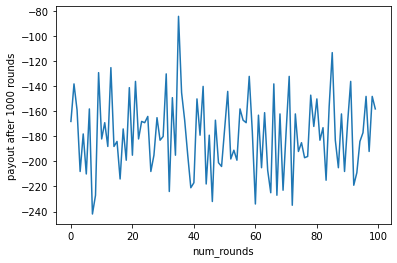

Average payout after 1000 rounds is -178.58


In [3]:
env.reset()
num_hands = 1000 # Payout calculated over num_hands
num_rounds = 100 # num_hands simulated over num_rounds

average_payouts = []

for sample in range(num_rounds):
    round = 1
    total_payout = 0 # to store total payout over 'num_hands'
    
    while round <= num_hands:
        action = 0  # take random action 
#         print('ACTION: ' + str(action))
        
        obs, payout, is_done, info = env.step(action)
#         print('OBS: ' + str(obs))
#         print('PAYOUT: ' + str(payout))
#         print('ID_DONE: ' + str(is_done))
#         print('INFO: ' + str(info))

        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

plt.plot(average_payouts)                
plt.xlabel('num_rounds')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_hands, sum(average_payouts)/num_rounds))

In [15]:
# valid_actions = list(range(env.action_space.n))
# valid_actions

# list(range(env.observation_space[0].n))

In [5]:
import random

class Agent():
    def __init__(self, env, t=0.1, epsilon=1.0, alpha=0.01, gamma=0.95, num_hands_to_train=30000):
        self.env = env

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(self.env.action_space.n))

        # Set parameters of the learning agent
        self.Q = dict()          # Q-table 
        self.t = t               # tempurature
        self.epsilon = epsilon   # Random exploration rate
        self.alpha = alpha       # Learning rate
        self.gamma = gamma       # Discount rate- closer to 1 learns well into distant future

        self.num_hands_to_train = num_hands_to_train # Change epsilon each episode based on this
        self.small_decrement = (0.1 * epsilon) / (0.3 * num_hands_to_train) # reduces epsilon slowly
        self.big_decrement = (0.8 * epsilon) / (0.4 * num_hands_to_train) # reduces epilon faster

        self.num_hands_to_train_left = num_hands_to_train

    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
        if self.num_hands_to_train_left > 0.7 * self.num_hands_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_hands_to_train_left > 0.3 * self.num_hands_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_hands_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0

        self.num_hands_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        
        return max(self.Q[observation].values())
    

    def choose_action(self, observation):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)
        
        
        probs = np.array(list(self.Q[observation].values()))/self.t
        probs = np.exp(probs) / np.sum(np.exp(probs))
        
        action = np.random.choice(len(probs), 1, p=probs)[0]
        
        # action = np.random.choice(np.where(probs == np.max(probs))[0])
        
        # maxQ = self.get_maxQ(observation)
        # # uniformly distributed random number > epsilon happens with probability 1-epsilon
        # if random.random() > self.epsilon:
        #     maxQ = self.get_maxQ(observation)

        #     # multiple actions could have maxQ- pick one at random in that case
        #     # this is also the case when the Q value for this observation were just set to 0.0
            
        #     action = random.choice([k for k in self.Q[observation].keys()
        #                             if self.Q[observation][k] == maxQ])
        # else:
        #     action = random.choice(self.valid_actions)
        #     print(action)

        # self.update_parameters()

        return action


    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives a reward.
        This function does not consider future rewards
        when conducting learning.
        """

        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])

In [6]:
np.random.choice(len([0.1,0.9]), 1, p=[0.1,0.9])[0]

1

In [7]:
import matplotlib.pyplot as plt

agent = Agent(env=env, t=0.1, epsilon=1.0, alpha=0.1, gamma=0, num_hands_to_train=30000)


def train(agent,num_hands,num_episode):
    payouts = []
    total_games = 0
    total_wins = 0

    observation = env.reset()
    for sample in range(num_episode):
        round = 1
        total_payout = 0 # to store total payout over 'num_hands'
        # Take action based on Q-table of the agent and learn based on that until 'num_hands_to_train' = 0
        while round <= num_hands:
            action = agent.choose_action(observation)
            next_observation, payout, is_done, _ = env.step(action)
            agent.learn(observation, action, payout, next_observation)
            total_payout += payout
            observation = next_observation
            if is_done:
                if payout == -1:
                    total_wins += 1
                total_games += 1
                observation = env.reset() # Environment deals new cards to player and dealer
                round += 1
        payouts.append(total_payout)
        
    return payouts, total_wins, total_games


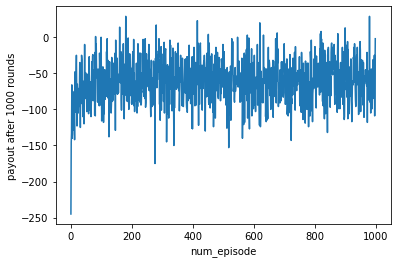

Average payout after 1000 rounds is -61.69
Average player win rate after 1000 rounds is 0.487568


In [8]:
# Plot payout per 1000 episodes for episode
num_hands=1000
num_episode = 1000
payouts, total_wins, total_games = train(agent,num_hands,num_episode)
plt.plot(payouts)           
plt.xlabel('num_episode')
plt.ylabel('payout after 1000 rounds')
plt.show()      

print ("Average payout after {} rounds is {}".format(num_hands, sum(payouts)/(num_episode)))
print ("Average player win rate after {} rounds is {}".format(num_hands, total_wins/total_games))

### Hyperparamter choosing

In [9]:
params_softmax = {'lr': [0.01,0.05,0.1,0.2],
          'temp':[0.05,0.1,0.2,0.5],
          'optm':'softmax',}

In [10]:
%matplotlib widget
def run_experiment(params):
    num_hands=1000
    num_episode = 1000
    history = {}
    for lr in params['lr']:
        for temp in params['temp']:
                agent = Agent(env=env, t=temp, epsilon=1.0, alpha=lr, gamma=0, num_hands_to_train=30000)
                payouts, total_wins, total_games = train(agent,num_hands,num_episode)
                name = f"lr_{lr}_temp_{temp}"
                history[name] = payouts
    return history

In [11]:
history_softmax = run_experiment(params_softmax)

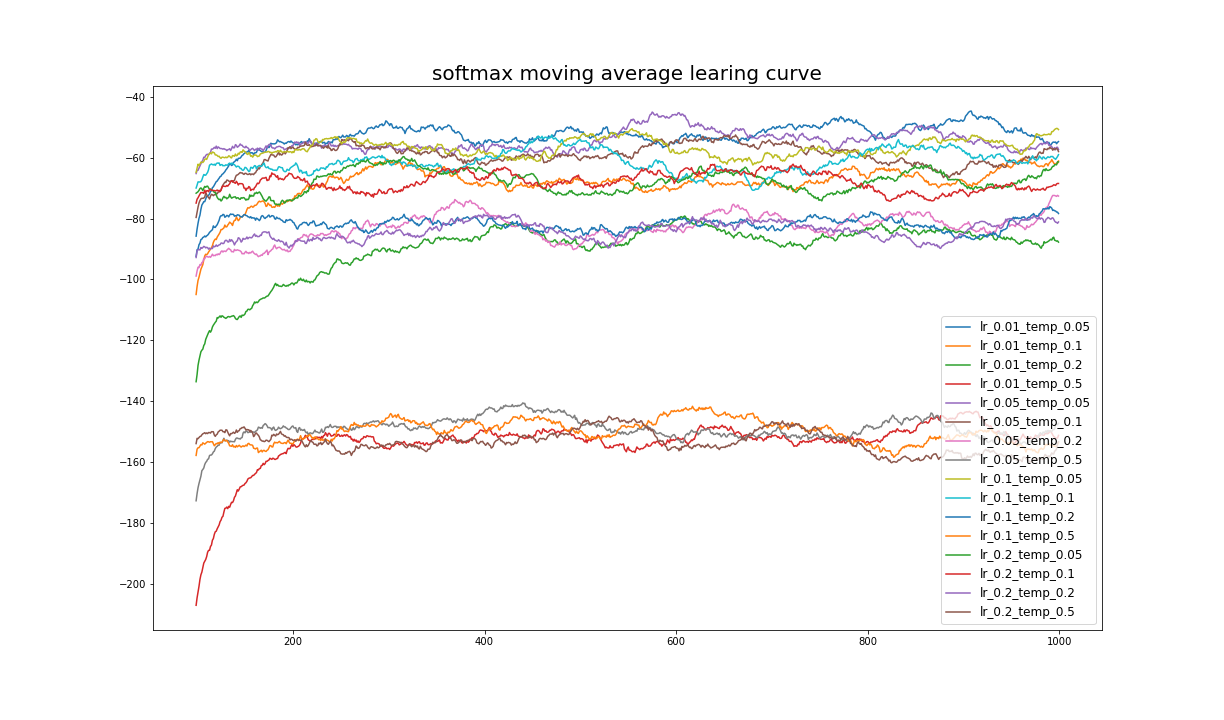

In [12]:
import mplcursors
import pandas as pd

def plot_moving_avg(dict, n=50, name = None):
    for k,v in dict.items():
        dict[k] = pd.Series(v).rolling(n).mean()
        
    plt.figure(figsize=(17,10))
    # plt.axes(ylim=(-34,-29)) 
    for k,v in dict.items():
        plt.plot(v,label=k)
    plt.legend(fontsize=12)
    plt.title(f"{name} moving average learing curve",fontsize=20)
    mplcursors.cursor(hover=True)
    plt.show()  
his = history_softmax    
plot_moving_avg(his, n=100, name = 'softmax')

## Strategy

In [16]:
agent1 = Agent(env=env, t=0.05, epsilon=1.0, alpha=0.05, gamma=0, num_hands_to_train=30000)


num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples
total_wins = 0
total_games = 0
payouts = []

observation = env.reset()
round = 1
total_payout = 0 # to store total payout over 'num_rounds'
# Take action based on Q-table of the agent and learn based on that until 'num_hands_to_train' = 0
while round <= num_rounds * num_samples:
    action = agent.choose_action(observation)
    next_observation, payout, is_done, _ = env.step(action)
    agent.learn(observation, action, payout, next_observation)
    payouts.append(payout)
    observation = next_observation
    if is_done:
        if payout == -1:
            total_wins += 1
        total_games += 1
        observation = env.reset() # Environment deals new cards to player and dealer
        round += 1
        
        # observation = env.reset() # Environment deals new cards to player and dealer
        # round += 1

num_observations = 0        
list_players_hand = range(2, 22)
list_dealers_upcard = range(1, 11)


def readable_action(observation, agent):
    """ 
    Pass observation to agent and get human readable action
    H is hit, S is stick and '-' means the state is unseen and a random action is taken
    """
    if observation not in agent.Q:
        action = "-"
    else:
        action = "H" if agent.choose_action(observation) else "S"    
    return action

# Print headers to give more information about output
print ("{:^10} | {:^50} | {:^50}".format("Player's","Dealer's upcard when ace is not usable", "Dealer's upcard when ace is usable"))
print ("{0:^10} | {1} | {1}".format("Hand", ['A' if upcard==1 else str(upcard) 
                                                        for upcard in list_dealers_upcard]))
print (''.join(['-' for _ in range(116)]))
for players_hand in list_players_hand:
    actions_usable = []
    actions_not_usable = []
    for dealers_upcard in list_dealers_upcard:
        observation = (players_hand, dealers_upcard, False)
        actions_not_usable.append(readable_action(observation, agent))
        observation = (players_hand, dealers_upcard, True)
        actions_usable.append(readable_action(observation, agent))
    
    print ("{:>10} | {} | {}".format(players_hand, actions_not_usable, actions_usable))

    
# print ("Average payout after {} rounds is {}".format(num_rounds, sum(payouts)/num_samples))
print ("Average payout after {} rounds is {}".format(num_hands, sum(payouts)/(num_samples)))
print ("Average player win rate after {} rounds is {}".format(num_hands, total_wins/total_games))

 Player's  |       Dealer's upcard when ace is not usable       |         Dealer's upcard when ace is usable        
   Hand    | ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'] | ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10']
--------------------------------------------------------------------------------------------------------------------
         2 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         3 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         4 | ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         5 | ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         6 | ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         7 | ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'